# Estimating VaR in EURUSD from IV using ML and QR

## Model Evaluation

In [1]:
import datetime
import pandas as pd
import numpy as np
import pickle
import joblib
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import dataframe_image as dfi

In [2]:
pd.set_option('display.float_format','{:.4f}'.format)

In [3]:
with open('data_scale.pickle', 'rb') as f:
    data_scale = pickle.load(f)

with open('model_qr.pickle', 'rb') as f:
    model_qr = pickle.load(f)

In [4]:
quantiles = [0.01, 0.025, 0.05, 0.95, 0.975, 0.99]

In [5]:
q_str = [str(i) for i in quantiles]

In [6]:
df_spot_os_x = data_scale['df_spot_os'].iloc[:,:-1]
df_spread_os_x = data_scale['df_spread_os'].iloc[:,:-1]

df_spot_os_y = data_scale['df_spot_os'].iloc[:,-1]
df_spread_os_y = data_scale['df_spread_os'].iloc[:,-1]

In [7]:
dt_end = datetime.datetime(2020, 12, 31)
df_spot_os_x = df_spot_os_x[df_spot_os_x.index<dt_end]
df_spread_os_x = df_spread_os_x[df_spread_os_x.index<dt_end]
df_spot_os_y = df_spot_os_y[df_spot_os_y.index<dt_end]
df_spread_os_y = df_spread_os_y[df_spread_os_y.index<dt_end]

In [8]:
models_dict = dict()
models_dict['QR'] = model_qr
models_dict['RF'] = joblib.load('rf_models.pkl')
models_dict['XGB1'] = joblib.load('xgb1_models.pkl')
models_dict['XGB2'] = joblib.load('xgb2_models.pkl')
models_dict['LGB1'] = joblib.load('lgb1_models.pkl')
models_dict['LGB2'] = joblib.load('lgb2_models.pkl')

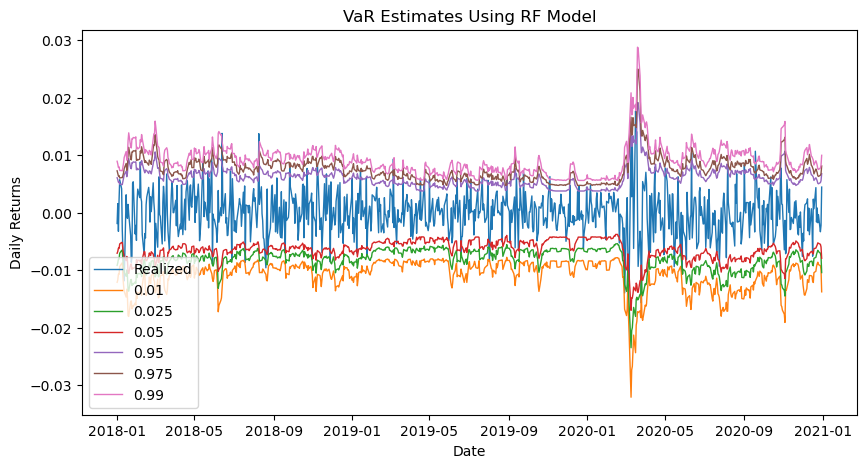

In [9]:
key = "RF"
rf_dict = dict()
X = df_spread_os_x
y_actual = df_spread_os_y
for a in quantiles:
    rf_dict[a] = models_dict[key][a].predict(X)
df_rf = pd.DataFrame(rf_dict, index=df_spot_os_y.index)
df_rf['Realized'] = y_actual

fig_rf, ax_rf = plt.subplots(figsize=(10,5))
ax_rf.plot(df_rf.index, df_rf['Realized'],
           label='Realized', linewidth=1)
for a in quantiles:
    ax_rf.plot(df_rf.index, df_rf[a],
               label=str(a), linewidth=1)

ax_rf.legend(loc='lower left')
ax_rf.set_title(f"VaR Estimates Using {key} Model")
ax_rf.set_xlabel("Date")
ax_rf.set_ylabel("Daily Returns")
fig_rf.savefig(f"VaR_{key}.png", dpi=300, bbox_inches='tight')

In [10]:
# evaluation metrics
def breach_ratio(y_pred, y_actual):
    num_breaches = (y_pred > y_actual).sum()
    ratio = num_breaches / len(y_pred)
    return ratio

def sum_if_breach(y_pred, y_actual):
    if y_pred.mean() > 0:
        breach_sum = (y_actual - y_pred)[y_pred < y_actual].sum()
    else:
        breach_sum = (y_actual - y_pred)[y_pred > y_actual].sum()
    return breach_sum

def sum_if_no_breach(y_pred, y_actual):
    if y_pred.mean() > 0:
        no_breach_sum = (y_pred - y_actual)[y_pred > y_actual].sum()
    else:
        no_breach_sum = (y_pred - y_actual)[y_pred < y_actual].sum()
    return no_breach_sum

def Max_VaR(y_pred):
    Max_Value = max(y_pred)
    return Max_Value

def Min_VaR(y_pred):
    Min_Value = min(y_pred)
    return Min_Value

In [11]:
key = "RF"
rf_perf = dict()
X = df_spread_os_x
y_actual = df_spread_os_y
y_preds = [models_dict[key][a].predict(X) for a in quantiles]
rf_perf['Breach Ratio'] = [breach_ratio(y, y_actual) for y in y_preds]
rf_perf['Sum if breach'] = [sum_if_breach(y, y_actual) for y in y_preds]
rf_perf['Sum if no breach'] = [sum_if_no_breach(y, y_actual) for y in y_preds]
rf_perf['Min. Var'] = [Max_VaR(y) for y in y_preds]
rf_perf['Max. Var'] = [Min_VaR(y) for y in y_preds]
df_rf_perf = pd.DataFrame(rf_perf, index=q_str).T

In [12]:
title = f"{key} Performance Out-of-sample"
dfi.export(df_rf_perf, f"{title}.png", dpi=300)
print(title)
df_rf_perf

RF Performance Out-of-sample


,0.01,0.025,0.05,0.95,0.975,0.99
Breach Ratio,0.0026,0.0192,0.0498,0.9476,0.9808,0.9923
Sum if breach,-0.0018,-0.0165,-0.0579,0.0652,0.0249,0.0106
Sum if no breach,-8.5317,-6.5014,-5.1003,4.8848,5.9917,7.1706
Min. Var,-0.0078,-0.0054,-0.0038,0.0191,0.0249,0.0288
Max. Var,-0.0321,-0.0235,-0.0170,0.0038,0.0047,0.0056


In [13]:
breach_ratios = dict()
for key, model in models_dict.items():
    if key == "QR":
        X = df_spot_os_x[['IV_ATM', 'RR_25D']]
        y_actual = df_spot_os_y
    else:
        X = df_spread_os_x
        y_actual = df_spread_os_y
    y_preds = [model[a].predict(X) for a in quantiles]
    breach_ratios[key] = [breach_ratio(y, y_actual) for y in y_preds]
df_breach = pd.DataFrame(breach_ratios, index=q_str).T

In [14]:
title = f"Summary of all model breach ratios during the out-of-sample period"
dfi.export(df_breach, f"{title}.png", dpi=300)
print(title)
df_breach

Summary of all model breach ratios during the out-of-sample period


,0.01,0.025,0.05,0.95,0.975,0.99
QR,0.0038,0.0204,0.0473,0.9413,0.9783,0.9911
RF,0.0026,0.0192,0.0498,0.9476,0.9808,0.9923
XGB1,0.0026,0.0192,0.0498,0.9451,0.9783,0.9923
XGB2,0.0038,0.0051,0.0217,0.9808,0.9936,0.9962
LGB1,0.0026,0.0192,0.0498,0.9464,0.9770,0.9923
LGB2,0.0102,0.0204,0.0396,0.9847,0.9911,0.9962


In [15]:
breach_values = dict()
def abs_sum(data):
    return sum([abs(i) for i in data])

for key, model in models_dict.items():
    if key == "QR":
        X = df_spot_os_x[['IV_ATM', 'RR_25D']]
        y_actual = df_spot_os_y
    else:
        X = df_spread_os_x
        y_actual = df_spread_os_y
    y_preds = [model[a].predict(X) for a in quantiles]
    sum_ibs = [sum_if_breach(y, y_actual) for y in y_preds]
    sum_inbs = [sum_if_no_breach(y, y_actual) for y in y_preds]
    breach_values[(key,"i.b.")] = sum_ibs + [abs_sum(sum_ibs)]
    breach_values[(key,"i.n.b.")] = sum_inbs + [abs_sum(sum_inbs)]
df_values = pd.DataFrame(breach_values, index=(q_str+["|Sum|"])).T

In [16]:
title = f"Breach values, i.b., and if not breach values, i.n.b., out-of-sample period."
dfi.export(df_values, f"{title}.png", dpi=300)
print(title)
df_values

Breach values, i.b., and if not breach values, i.n.b., out-of-sample period.


0.01   0.025    0.05   0.95  0.975    0.99   |Sum|
QR   i.b.   -0.0044 -0.0188 -0.0575 0.0683 0.0270  0.0116  0.1877
     i.n.b. -8.3353 -6.4025 -5.0948 4.8522 5.9231  7.1088 37.7167
RF   i.b.   -0.0018 -0.0165 -0.0579 0.0652 0.0249  0.0106  0.1768
     i.n.b. -8.5317 -6.5014 -5.1003 4.8848 5.9917  7.1706 38.1804
XGB1 i.b.   -0.0025 -0.0161 -0.0566 0.0658 0.0258  0.0107  0.1775
     i.n.b. -8.5380 -6.4925 -5.1315 4.8744 5.9712  7.1472 38.1547
XGB2 i.b.   -0.0023 -0.0060 -0.0246 0.0313 0.0126  0.0023  0.0791
     i.n.b. -9.9795 -7.9917 -6.2788 6.4203 8.4854 10.6324 49.7880
LGB1 i.b.   -0.0021 -0.0162 -0.0567 0.0660 0.0257  0.0106  0.1773
     i.n.b. -8.5018 -6.4948 -5.1347 4.8709 5.9636  7.1576 38.1233
LGB2 i.b.   -0.0080 -0.0226 -0.0565 0.0340 0.0171  0.0062  0.1443
     i.n.b. -9.0611 -7.0111 -5.5877 6.4976 7.5048  9.1837 44.8460

In [17]:
import vartests

0.2.2


In [18]:
def p_val(y_pred, y_actual, a):
    if a < 0.5:
        violations = y_pred > y_actual
    else:
        violations = y_pred < y_actual
    test = vartests.duration_test(violations, conf_level=a)
    val = test['log-likelihood ratio test statistic']
    if type(val) == np.float64:
        output = val
    else:
        output = val[0]
    return output

In [19]:
p_values = dict()
for key, model in models_dict.items():
    if key == "QR":
        X = df_spot_os_x[['IV_ATM', 'RR_25D']]
        y_actual = df_spot_os_y
    else:
        X = df_spread_os_x
        y_actual = df_spread_os_y
    y_preds = [(model[a].predict(X), a) for a in quantiles]
    p_values[key] = [p_val(y[0], y_actual, y[1]) for y in y_preds]
df_pval = pd.DataFrame(p_values, index=q_str).T

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_

In [20]:
title = "The p-values for the Christoffersen test, out-of-sample. High values indicate high accuracy."
dfi.export(df_pval, f"{title}.png", dpi=300)
print(title)
df_pval

The p-values for the Christoffersen test, out-of-sample. High values indicate high accuracy.


,0.01,0.025,0.05,0.95,0.975,0.99
QR,0.8601,0.6090,0.3712,0.0184,0.0618,0.2374
RF,0.6920,0.7058,0.6568,0.0626,0.0865,0.2084
XGB1,0.6920,0.7058,0.4377,0.0283,0.0618,0.2084
XGB2,0.0206,0.0256,0.3717,0.0410,0.0118,0.7296
LGB1,0.6920,0.7058,0.2222,0.0790,0.0367,0.2084
LGB2,0.4477,0.7371,0.6889,0.0368,0.1171,0.7296
